# Imports

In [20]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import squarify
import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

Dowanload and load catalan stopwords from `spacy`.

In [21]:
!python -m spacy download ca_core_news_sm
nlp = spacy.load("ca_core_news_sm")
stopwords = nlp.Defaults.stop_words
print(stopwords)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 16.0 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('ca_core_news_sm')
{'veu', 'què', 'sabeu', 'estem', 'algunes', 'en', 'tantes', 'tons', 'va', 'podeu', 'consigueix', 'nostre', 'mateixes', 'ser', "d'una", 'teniu', 'està', 'solament', 'oh', 'sons', 'dintre', 'li', 'semblant', 'estat', 'altre', 'moltes', 'per', 'sou', 'només', 'ans', 'contra', 'cadascuna', 'seves', 'van', 'mode', 'tant', 'doncs', 'poques', 'tanta', 'durant', 'eres', 'teves', 'us', 'així', 'fa', 'éssent', 'donat', 'estic', 'després', 'molt', "d'uns", 'pocs', 'saps', 'molts', 'nostra', 'seus', 'semblants', 'estaven', 'sota', 'tot', 'meva', 'tan', 'potser', 'on', 'vaig', 'altra', "d'un", 'quant', 'son', 'vostre', 'ses', 'com', 'malgrat', 'cadascú', 'ambdós', 'faig', 'consegueixo', 'dels', 'els', 'quines', 'meu', 'esteu', 'de', "m'he", "d'unes", "n'hi", 'uns', 'les', "t'han", 'vam', 'ens', 'unes', 'quan',

# Load and process csv data

In [22]:
data = pd.read_csv('../data/train.csv')

In [23]:
texts = data['text']
labels = data['class']
year = data['year']

## Remove stopwords + leading and trailing quotes

In [24]:
def remove_stopwords(sentence):
    sentence = ' '.join([word for word in sentence.split() if word not in stopwords])

    return sentence

preprocessed_texts = []
for sentence in texts:
    preprocessed_texts.append(remove_stopwords(sentence))

In [25]:
for sentence in preprocessed_texts:
    if sentence.startswith(("'", '"')):
        sentence = sentence[1:]
    if sentence.endswith(("'", '"')):
        sentence = sentence[:-1]

In [26]:
print(np.random.choice(preprocessed_texts, 15, replace=False))

["Nomenament funcionaris l'any 2012."
 'Modificació cartipàs municipal renúncia voluntària.'
 "Aprovació inicial disposició addicional l'Ordenança reguladora taxa l'ocupació via pública taules cadires l'exercici 2020."
 'Contractació personal.'
 'Notificació sanció infracció consistent exercir activitat haver-ne fet comunicació.'
 "Incoació d'expedients baixa d'ofici Padró Municipal d'Habitants."
 "Resolució d'atorgament denegació definitiva convocatòria subvencions activitats projectes promoció reforç l'economia social solidària, any 2020."
 "Aprovació inicial projecte d'intervencions camp futbol municipal Sant Fruitós Bages."
 "Aprovació inicial pressupost general l'exercici 2021."
 "Formalització contracte gestió bar ubicat pavelló municipal d'esports camp futbol."
 'Delegació celebració matrimoni civil.'
 'Convocatòria subvencions sector comercial serveis.'
 'Convocatoria subvenciones para los proyectos carácter deportivo.'
 'Nomenament guàrdies/agents Policia Local funcionaris int

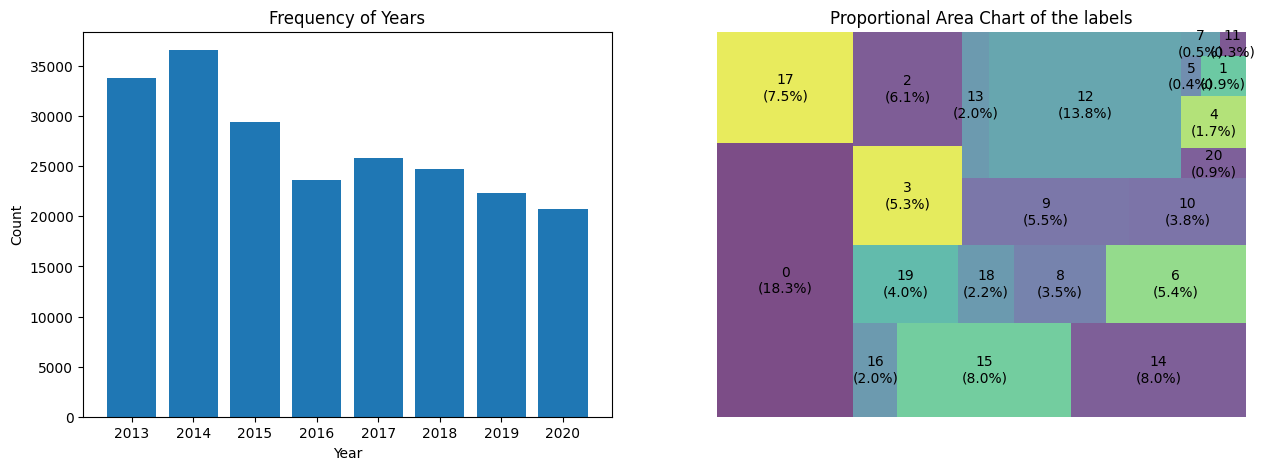

In [27]:
year_counts = Counter(year)
sorted_years = sorted(year_counts)
frequencies_years = [year_counts[year] for year in sorted_years]

lable_counts = Counter(labels)
sorted_lables = sorted(lable_counts)
frequencies_labels = [lable_counts[label] for label in sorted_lables]
labels_with_pct = [f"{label}\n({size/sum(frequencies_labels):.1%})" for label, size in lable_counts.items()]

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].bar(sorted_years, frequencies_years)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Count')
ax[0].set_title('Frequency of Years')


squarify.plot(sizes=lable_counts.values(), label=labels_with_pct, alpha=0.7, ax=ax[1])
ax[1].axis('off')
ax[1].set_title("Proportional Area Chart of the labels")

# ax[1].bar(sorted_lables, frequencies_labels)
# ax[1].set_xlabel('Label')
# ax[1].set_ylabel('Count')
# ax[1].set_title('Label Frequencies')

plt.show()

## Convert texts to TF-IDF vectors

In [28]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(preprocessed_texts).toarray()
y = np.array(labels)

## Create a PyTorch dataset

In [29]:
class TextDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_dataset = DataLoader(TextDataset(X_train, y_train), batch_size=32, shuffle=True)
test_dataset = DataLoader(TextDataset(X_test, y_test), batch_size=32)

# Basic NN

## Model Class

In [16]:
# Define the FCNN model
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## Initialize Model, Loss and Optimizer

In [17]:
fcnn = FCNN(input_size=1000, hidden_size=256, num_classes=21)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001)

## Training and Testing

In [18]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for step, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(data), len(train_loader.dataset),
                100. * step / len(train_loader), loss.item()))

In [19]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_function(output, target).item() * target.size(0)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

In [20]:
num_epochs = 5
for epoch in range(1, num_epochs + 1):
    train(fcnn, train_dataset, optimizer, epoch)
    test(fcnn, test_dataset)

Train Epoch: 1 [0/151881 (0%)]	Loss: 3.045285
Train Epoch: 1 [3200/151881 (2%)]	Loss: 1.659530
Train Epoch: 1 [6400/151881 (4%)]	Loss: 0.800069
Train Epoch: 1 [9600/151881 (6%)]	Loss: 0.381011
Train Epoch: 1 [12800/151881 (8%)]	Loss: 0.414087
Train Epoch: 1 [16000/151881 (11%)]	Loss: 0.458306
Train Epoch: 1 [19200/151881 (13%)]	Loss: 0.380540
Train Epoch: 1 [22400/151881 (15%)]	Loss: 0.164928
Train Epoch: 1 [25600/151881 (17%)]	Loss: 0.217871
Train Epoch: 1 [28800/151881 (19%)]	Loss: 0.135074
Train Epoch: 1 [32000/151881 (21%)]	Loss: 0.268345
Train Epoch: 1 [35200/151881 (23%)]	Loss: 0.304954
Train Epoch: 1 [38400/151881 (25%)]	Loss: 0.245023
Train Epoch: 1 [41600/151881 (27%)]	Loss: 0.156764
Train Epoch: 1 [44800/151881 (29%)]	Loss: 0.371206
Train Epoch: 1 [48000/151881 (32%)]	Loss: 0.452811
Train Epoch: 1 [51200/151881 (34%)]	Loss: 0.323723
Train Epoch: 1 [54400/151881 (36%)]	Loss: 0.161352
Train Epoch: 1 [57600/151881 (38%)]	Loss: 0.315475
Train Epoch: 1 [60800/151881 (40%)]	Loss: 0

# Transformer model

In [34]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import evaluate

Hugging face BERT-like models expects tokenized inputs (This is done by lazy-tokenization):

In [35]:
X_train_tok, X_test_tok, y_train_tok, y_test_tok = train_test_split(preprocessed_texts, labels, test_size=0.25, random_state=42)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch['text'],
                     padding='max_length',
                     truncation=True
                     )

# Convert to HuggingFace Dataset object to be able to use .map()
train_dataset = Dataset.from_dict({"text": X_train_tok, "label": y_train_tok})
test_dataset  = Dataset.from_dict({"text": X_test_tok,  "label": y_test_tok})
train_tok = train_dataset.map(tokenize, batched=True, remove_columns=["text"])
test_tok  = test_dataset.map(tokenize, batched=True, remove_columns=["text"])

train_tok.set_format("torch")
test_tok.set_format("torch")

Map: 100%|██████████| 54244/54244 [00:06<00:00, 7959.94 examples/s]


APUNTAR EN EL PPT QUÈ MERDES ÉS EL BERT-BASE-UNCASED:

- **BERT** stands for **Bidirectional Encoder Representations from Transformers**.

- It’s a pretrained Transformer-based model developed by Google in 2018.

- Designed to understand language **bidirectionally** (looking at context from both left and right).

- `"base"` means it’s the smaller version of BERT (compared to `bert-large`).

- `"uncased"` means it does not distinguish uppercase and lowercase letters — input text is lowercased before tokenization.


When to Use:
- Great general-purpose language model.

- Lowercased text input, so works best on texts that are not case-sensitive.

- Efficient enough for many applications while maintaining strong performance.

Model Specs:

| Feature                | Description                 |
|------------------------|-----------------------------|
| Layers (Transformer blocks) | 12                      |
| Hidden size            | 768                         |
| Attention heads        | 12                          |
| Parameters             | ~110 million                |
| Vocabulary size        | 30,522 tokens               |
| Max input length       | 512 tokens                  |

In [36]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=21,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
